[PROVENANCE]: Start
    X = <Var 'df'>
Result:
―――――――
                                order_id                       customer_id  \
0       e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1       e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
2       e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
3       53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
4       47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
...                                  ...                               ...   
119138  63943bddc261676b46f01ca7ac2f7bd8  1fca14ff2861355f6e5f14306ff977a7   
119139  83c1379a015df1e13d02aae0204711ab  1aa71eb042121263aafbe80c1b562c9c   
119140  11c177c8e97725db2631073c19f07b62  b331b74b18dc79bcdf6532d51e1637c1   
119141  11c177c8e97725db2631073c19f07b62  b331b74b18dc79bcdf6532d51e1637c1   
119142  66dea50a8b16d9b4dee7af250b4be1a5  edb027a75a1449115f6b43211ae02a24   

       o

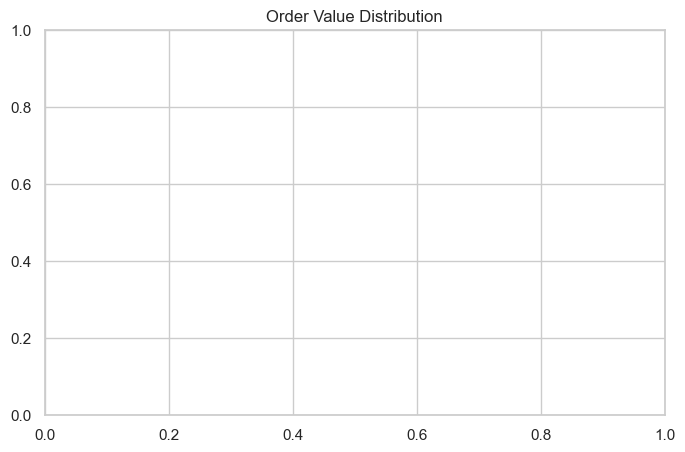

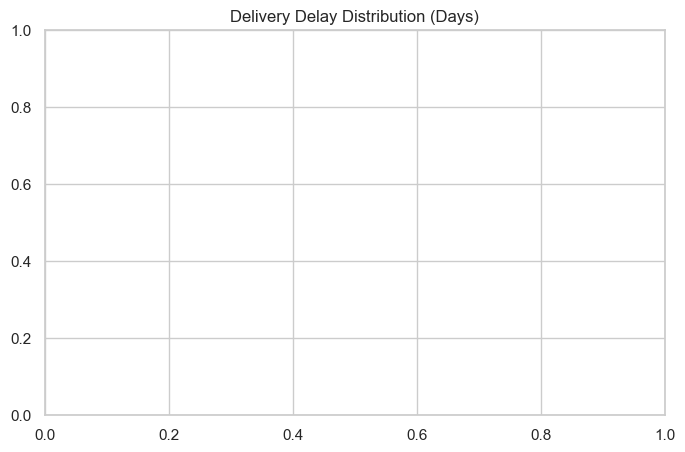

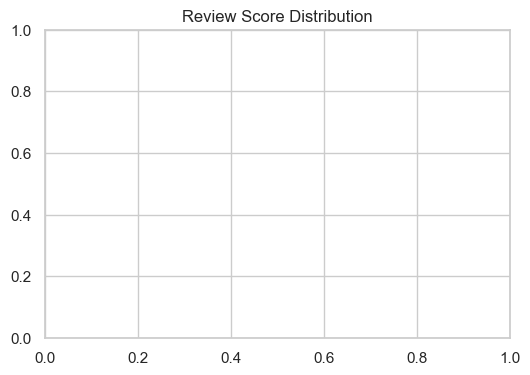

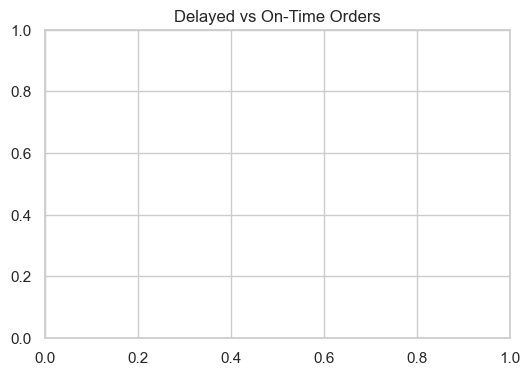

[PROVENANCE]: Start
[PROVENANCE]: END
[PROVENANCE]: Start
[PROVENANCE]: END
[PROVENANCE]: Start
[PROVENANCE]: END
[PROVENANCE]: Start
[PROVENANCE]: END
[PROVENANCE]: Start
[PROVENANCE]: END
[PROVENANCE]: Start
[PROVENANCE]: END
[PROVENANCE]: Start
    X = <CallMethod 'drop'>
Result:
―――――――
        freight_value   price  payment_installments  order_value  review_score
0                8.72   29.99                   1.0        29.99           4.0
1                8.72   29.99                   1.0        29.99           4.0
2                8.72   29.99                   1.0        29.99           4.0
3               22.76  118.70                   1.0       118.70           4.0
4               19.22  159.90                   3.0       159.90           5.0
...               ...     ...                   ...          ...           ...
119136          16.09  139.90                   3.0       139.90           5.0
119137          13.08   72.00                   3.0        72.00           5

AttributeError: 'Sentinels' object has no attribute 'copy'

In [1]:
# =====================================================
# Brazilian E-Commerce Public Dataset (Olist)
# End-to-End Data Analysis
# =====================================================


"""
Objective:
Analyze Brazilian e-commerce orders to understand delivery performance,
customer satisfaction, and key operational drivers.
"""

# -------------------------------
# 1. Imports & Data Loading
# -------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import skrub
from skrub import ToDatetime
from monkey_patching_v02_data_provenance import set_provenance, enter_provenance_mode_dataop, enter_provenance_mode_var
set_provenance(skrub._data_ops._evaluation,"evaluate", provenance_func=enter_provenance_mode_dataop)
set_provenance(skrub._data_ops._data_ops.Var,"compute", provenance_func=enter_provenance_mode_var)
sns.set(style="whitegrid")

base_path = "/kaggle/input/brazilian-ecommerce"

customers = pd.read_csv('C:/Users/teodo/Desktop/github/rdepro_skrub_provenance/monkey_patching_v02/data_provenance/kagglePipelines/data/datasets/olistbr/brazilian-ecommerce/versions/2/olist_customers_dataset.csv')
orders = pd.read_csv('C:/Users/teodo/Desktop/github/rdepro_skrub_provenance/monkey_patching_v02/data_provenance/kagglePipelines/data/datasets/olistbr/brazilian-ecommerce/versions/2/olist_orders_dataset.csv')
order_items = pd.read_csv('C:/Users/teodo/Desktop/github/rdepro_skrub_provenance/monkey_patching_v02/data_provenance/kagglePipelines/data/datasets/olistbr/brazilian-ecommerce/versions/2/olist_order_items_dataset.csv')
payments = pd.read_csv('C:/Users/teodo/Desktop/github/rdepro_skrub_provenance/monkey_patching_v02/data_provenance/kagglePipelines/data/datasets/olistbr/brazilian-ecommerce/versions/2/olist_order_payments_dataset.csv')
reviews = pd.read_csv('C:/Users/teodo/Desktop/github/rdepro_skrub_provenance/monkey_patching_v02/data_provenance/kagglePipelines/data/datasets/olistbr/brazilian-ecommerce/versions/2/olist_order_reviews_dataset.csv')

# -------------------------------
# 2. Data Preparation & Merging
# -------------------------------
#df = (
 #   orders
  #  .merge(customers, on="customer_id", how="left")
   # .merge(order_items, on="order_id", how="left")
    #.merge(payments, on="order_id", how="left")
    #.merge(reviews[["order_id", "review_score"]], on="order_id", how="left")
#)
df = skrub.var("df",   orders
  .merge(customers, on="customer_id", how="left")
    .merge(order_items, on="order_id", how="left")
    .merge(payments, on="order_id", how="left")
    .merge(reviews[["order_id", "review_score"]], on="order_id", how="left"))
# -------------------------------
# 3. Date Handling & Filtering
# -------------------------------
date_cols = [
    "order_purchase_timestamp",
    "order_delivered_customer_date",
    "order_estimated_delivery_date"
]

#for col in date_cols:
 #   df[col] = pd.to_datetime(df[col], errors="coerce")

toDateTimeEncoder = ToDatetime()
df= df.skb.apply(toDateTimeEncoder, cols= date_cols)

# Only delivered orders make sense for delay analysis
df = df[df["order_status"] == "delivered"]

# -------------------------------
# 4. Feature Engineering
# -------------------------------
#df["delivery_delay"] = (
 #   df["order_delivered_customer_date"] -
  #  df["order_estimated_delivery_date"]
#.dt.days

df = df.assign(delivery_delay = (
    df["order_delivered_customer_date"] -
    df["order_estimated_delivery_date"]
).dt.days)

#df["order_value"] = df["price"] + df["freight_value"]
df = df.assign(order_value = df["price"])

#df["is_delayed"] = (df["delivery_delay"] > 0).astype(int)
df = df.assign(is_delayed = (df["delivery_delay"] > 0).astype(int))
# -------------------------------
# 5. Data Cleaning
# -------------------------------
df = df.replace([np.inf, -np.inf], np.nan)

df = df.dropna(subset=[
    "order_value",
    "freight_value",
    "payment_installments",
    "review_score",
    "delivery_delay"
])

# Remove extreme outliers (realistic delivery window)
df = df[(df["delivery_delay"] >= -20) & (df["delivery_delay"] <= 60)]

# -------------------------------
# 6. Exploratory Data Analysis (EDA)
# -------------------------------
plt.figure(figsize=(8,5))
#sns.histplot(df["order_value"], bins=50) error: dataop type cannot be interpreted as integer
plt.title("Order Value Distribution")
plt.show()

plt.figure(figsize=(8,5))
#sns.boxplot(x=df["delivery_delay"]) same here
plt.title("Delivery Delay Distribution (Days)")
plt.show()

plt.figure(figsize=(6,4))
#sns.countplot(x="review_score", data=df) Data source must be a DataFrame or Mapping, not <class 'skrub._data_ops._data_ops.DataOp'>.
plt.title("Review Score Distribution")
plt.show()

plt.figure(figsize=(6,4))
#sns.countplot(x="is_delayed", data=df)  Data source must be a DataFrame or Mapping, not <class 'skrub._data_ops._data_ops.DataOp'>.
plt.title("Delayed vs On-Time Orders")
plt.show()

# -------------------------------
# 7. Modeling – Classification (Business-Oriented)
# -------------------------------
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

model_df = df[[
    "freight_value",
    "price",
    "payment_installments",
    "order_value",
    "review_score",
    "is_delayed"
]]

#X = model_df.drop("is_delayed", axis=1)
#y = model_df["is_delayed"]

X = model_df.drop("is_delayed", axis=1).skb.mark_as_X()
y = model_df["is_delayed"].skb.mark_as_y()

#X_train, X_test, y_train, y_test = train_test_split(
 #   X, y, test_size=0.2, random_state=42, stratify=y
#)

#clf = LogisticRegression(max_iter=1000)
#clf.fit(X_train, y_train)
#y_pred = clf.predict(X_test)

model = LogisticRegression(max_iter=1000)
clf = X.skb.apply(model, y=y)
split = clf.skb.train_test_split(random_state = 42)
learner = clf.skb.make_learner()
learner.fit(split["train"])
learner.score(split["test"])
y_pred = learner.predict(split["test"])


#print(classification_report(y_test, y_pred))
print(classification_report(split["y_test"], y_pred))

# -------------------------------
# 8. Model Interpretation
# -------------------------------
#coef_df = pd.DataFrame(
 #   learner.coef_[0],
  #  X.columns,
   # columns=["Coefficient"]
#).sort_values(by="Coefficient", ascending=False)

#coef_df
#SADLY, SKRUBLEARNER DOES NOT HAVE .COEF_ ATTRIBUTE, I LOOKED INTO THE DOCUMENTATION
# -------------------------------
# 9. Business Insights
# -------------------------------
"""
Key Insights:
- Higher freight costs significantly increase the probability of delivery delays.
- Payment installments correlate with delayed deliveries, indicating potential operational risk.
- Delayed orders are strongly associated with lower review scores.
- Delivery performance is a critical driver of customer satisfaction.
"""

# -------------------------------
# 10. Conclusion
# -------------------------------
"""
This project presents a realistic e-commerce analytics workflow using 100k+ orders.
By combining multiple datasets, engineering meaningful features, and shifting from
regression to classification, the analysis delivers actionable business insights
focused on logistics performance and customer experience.
"""
